# Corpus callosum's shape signature for segmentation error detection in large datasets

## Abstract

Corpus Callosum (CC) is a subcortical, white matter structure with great importance in clinical and research studies because its shape and volume are correlated with subject's characteristics and neurodegenerative diseases. CC segmentation is a important step for any medical, clinical or research posterior study. Currently, magnetic resonance imaging (MRI) is the main tool for evaluating brain because it offers the better soft tissue contrast. Particullary, segmentation in MRI difussion modality has great importante given information associated to brain microstruture and fiber composition.

In this work a method for detection of erroneous segmentations in large datasets is proposed based-on shape signature. Shape signature is obtained from segmentation, calculating curvature along contour using a spline formulation. A mean correct signature is used as reference for compare new segmentations through root mean square error. This method was applied to 145 subject dataset for three different segmentation methods in diffusion: Watershed, ROQS and pixel-based presenting high accuracy in error detection. This method do not require per-segmentation reference and it can be applied to any MRI modality and other image aplications.

In [2]:
## Functions

import sys
sys.path.append("../dev")

import bib_mri as FW
import numpy as np
import scipy as scipy
import scipy.misc as misc 
import matplotlib as mpl
import matplotlib.pyplot as plt
from numpy import genfromtxt
import platform

%matplotlib inline

def sign_extract(seg, resols): #Function for shape signature extraction
    splines = FW.get_spline(seg,smoothness)

    sign_vect = np.array([]).reshape(0,points) #Initializing temporal signature vector
    for resol in resols:
        sign_vect = np.vstack((sign_vect, FW.get_profile(splines, n_samples=points, radius=resol)))
    
    return sign_vect

def sign_fit(sig_ref, sig_fit): #Function for signature fitting
    dif_curv = []
    for shift in range(points):
        dif_curv.append(np.abs(np.sum((sig_ref - np.roll(sig_fit[0],shift))**2)))
    return np.apply_along_axis(np.roll, 1, sig_fit, np.argmin(dif_curv))

print "Python version: ", platform.python_version()
print "Numpy version: ", np.version.version
print "Scipy version: ", scipy.__version__
print "Matplotlib version: ", mpl.__version__

Python version:  2.7.6
Numpy version:  1.12.1
Scipy version:  0.18.1
Matplotlib version:  2.0.0


## Introduction

The Corpus Callosum (CC) is the largest white matter structure in the central nervous system that connects both brain hemispheres and allows the communication between them. The CC has great importance in research studies due to the correlation between shape and volume with some subject's characteristics, such as: gender, age, numeric and mathematical skills and handedness. In addition, some neurodegenerative diseases like Alzheimer, autism, schizophrenia and dyslexia could cause CC shape deformation.

CC segmentation is a necessary step for morphological and physiological features extraction in order to analyze the structure in image-based clinical and research applications. Magnetic Resonance Imaging (MRI) is the most suitable image technique for CC segmentation due to its ability to provide contrast between brain tissues however CC segmentation is challenging because of the shape and intensity variability between subjects, volume partial effect in diffusion MRI, fornex proximity and narrow areas in CC. Among the known MRI modalities, Diffusion-MRI arouses special interest to study the CC, despite its low resolution and high complexity, since it provides useful information related to the organization of brain tissues and the magnetic field does not interfere with the diffusion process itself.

Some CC segmentation approaches using Diffusion-MRI were found in the literature. Niogi et al. proposed a method based on thresholding, Freitas et al. e Rittner et al. proposed region methods based on Watershed transform, Nazem-Zadeh et al. implemented based on level surfaces, Kong et al. presented an clustering algorithm for segmentation, Herrera et al. segmented CC directly in diffusion weighted imaging (DWI) using a model based on pixel classification and Garcia et al. proposed a hybrid segmentation method based on active geodesic regions and level surfaces.

With the growing of data and the proliferation of automatic algorithms, segmentation over large databases is affordable. Therefore, error automatic detection is important in order to facilitate and speed up filter on CC segmentation databases. presented proposals for content-based image retrieval (CBIR) using shape signature of the planar object representation.

In this work, a method for automatic detection of segmentation error in large datasets is proposed based on CC shape signature. Signature offers shape characterization of the CC and therefore it is expected that a "typical correct signature" represents well any correct segmentation. Signature is extracted measuring curvature along segmentation contour. The method was implemented in three main stages: mean correct signature generation, signature configuration and method testing. The first one takes 20 corrects segmentations and generates one correct signature of reference (typical correct signature), per-resolution, using mean values in each point. The second stage stage takes 10 correct segmentations and 10 erroneous segmentations and adjusts the optimal resolution and threshold, based on mean correct signature, that lets detection of erroneous segmentations. The third stage labels a new segmentation as correct and erroneous comparing with the mean signature using optimal resolution and threshold.

<img src="../figures/workflow.png">

The comparison between signatures is done using root mean square error (RMSE). True label for each segmentation was done visually. Correct segmentation corresponds to segmentations with at least 50% of agreement with the structure. It is expected that RMSE for correct segmentations is lower than RMSE associated to erroneous segmentation when compared with a typical correct segmentation.

In [3]:
#Loading labeled segmentations
seg_label = genfromtxt('../dataset/Seg_Watershed/watershed_label.csv', delimiter=',').astype('uint8')

list_mask = seg_label[seg_label[:,1] == 0, 0][:20] #Extracting correct segmentations for mean signature
list_normal_mask = seg_label[seg_label[:,1] == 0, 0][20:30] #Extracting correct names
list_error_mask = seg_label[seg_label[:,1] == 1, 0][:10] #Extracting correct names

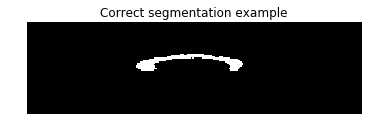

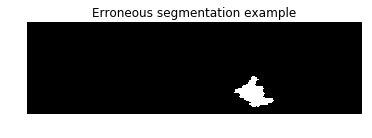

In [4]:
mask_correct = np.load('../dataset/Seg_Watershed/mask_wate_{}.npy'.format(list_mask[0]))
mask_error = np.load('../dataset/Seg_Watershed/mask_wate_{}.npy'.format(list_error_mask[0]))

plt.figure()
plt.axis('off')
plt.imshow(mask_correct,'gray',interpolation='none')
plt.title("Correct segmentation example")
plt.show()

plt.figure()
plt.axis('off')
plt.imshow(mask_error,'gray',interpolation='none')
plt.title("Erroneous segmentation example")
plt.show()

# Shape signature for comparison

Signature is a shape descriptor that measures the rate of variation along the segmentation contour. As shown in figure, the curvature $k$ in the pivot point $p$, with coordinates ($x_p$,$y_p$), is calculated using the next equation. This curvature depict the angle between the segments $\overline{(x_{p-ls},y_{p-ls})(x_p,y_p)}$ and $\overline{(x_p,y_p)(x_{p+ls},y_{p+ls})}$. These segments are located to a distance $ls>0$, starting in a pivot point and finishing in anterior and posterior points, respectively.
The signature is obtained calculating the curvature along all segmentation contour.

\begin{equation} \label{eq:per1}
k(x_p,y_p) = \arctan\left(\frac{y_{p+ls}-y_p}{x_{p+ls}-x_p}\right)-\arctan\left(\frac{y_p-y_{p-ls}}{x_p-x_{p-ls}}\right)
\end{equation}

<img src="../figures/curvature.png">

Signature construction is performed from segmentation contour of the CC. From contour, spline is obtained. Spline purpose is twofold: to get a smooth representation of the contour and to facilitate calculation of
the curvature using its parametric representation. The signature is obtained measuring curvature along spline. $ls$ is the parametric distance between pivot point and both posterior and anterior points and it determines signature resolution. By simplicity, $ls$ is measured in percentage of reconstructed spline points.

In order to achieve quantitative comparison between two signatures root mean square error (RMSE) is introduced. RMSE measures distance, point to point, between signatures $a$ and $b$ along all points $p$ of signatures.

\begin{equation} \label{eq:per4}
RMSE = \sqrt{\frac{1}{P}\sum_{p=1}^{P}(k_{ap}-k_{bp})^2}
\end{equation}

Frequently, signatures of different segmentations are not fitted along the 'x' axis because of the initial point on the spline calculation starts in different relative positions. This makes impossible to compare directly two signatures and therefore, a prior fitting process must be accomplished. The fitting process is done shifting one of the signature while the other is kept fixed. For each shift, RMSE between the two signatures is measured. The point giving the minor error is the fitting point. Fitting was done at resolution $ls = 0.35$. This resolution represents globally the CC's shape and eases their fitting.

After fitting, RMSE between signatures can be measured in order to achieve final quantitative comparison.

## Signature for segmentation error detection

For segmentation error detection, a typical correct signature is obtained calculating mean over a group of signatures from correct segmentations. Because of this signature could be used in any resolution, $ls$ must be chosen for achieve segmentation error detection. The optimal resolution must be able to return the greatest RMSE difference between correct and erroneous segmentation when compared with a typical correct signature.

In the optimal resolution, a threshold must be chosen for separate erroneous and correct segmentations. This threshold stays between RMSE associated to correct ($RMSE_E$) and erroneous ($RMSE_C$) signatures and it is given by the next equation where N (in percentage) represents proximity to correct or erroneous RMSE. If RMSE calculated over a group of signatures, mean value is applied.

\begin{equation} \label{eq:eq3}
th = N*(\overline{RMSE_E}-\overline{RMSE_C})+\overline{RMSE_C}
\end{equation}

# Experiments and results

In this work, comparison of signatures through RMSE is used for segmentation error detection in large datasets. For this, it will be calculated a mean correct signature based on 20 correct segmentation signatures. This mean correct signature represents a tipycal correct segmentation. For a new segmentation, signature is extracted and compared with mean signature.

For experiments, DWI from 152 subjects at the University of Campinas, were acquired on a Philips scanner Achieva 3T in the axial plane with a $1$x$1mm$ spatial resolution and $2mm$ slice thickness, along $32$ directions ($b-value=1000s/mm^2$, $TR=8.5s$, and $TE=61ms$). All data used in this experiment was acquired through a project approved by the research ethics committee from the School of Medicine at UNICAMP. From each acquired DWI volume, only the midsaggital slice was used.

Three segmentation methods were implemented to obtained binary masks over a 152 subject dataset: Watershed, ROQS and pixel-based. 40 Watershed segmentations were chosen as follows: 20 correct segmentations for mean correct signature generation and 10 correct and 10 erroneous segmentations for signature configuration stage. Watershed was chosen to generate and adjust the mean signature because of its higher error rate and its variability in the erroneous segmentation shape. These characteristics allow improve generalization. The method was tested on the remaining Watershed segmentations (108 masks) and two additional segmentations methods: ROQS (152 masks) and pixel-based (152 masks).

## Mean correct signature generation

In this work, segmentations based on Watershed method were used for implementation of the first and second stages. From the Watershed dataset, 20 correct segmentations were chosen. Spline for each one was obtained from segmentation contour. The contour was obtained using mathematical morphology, applying xor logical operation, pixel-wise, between original segmentation and the eroded version of itself by an structuring element b:

\begin{equation} \label{eq:per2}
G_E = XOR(S,S \ominus b)
\end{equation}

From contour, it is calculated spline. The implementation, is a B-spline (Boor's basic spline). This formulation has two parameters: degree, representing polynomial degrees of the spline, and smoothness, being the trade off between proximity and smoothness in the fitness of the spline. Degree was fixed in 5 allowing adequate representation of the contour. Smoothness was fixed in 700. This value is based on the mean quantity of pixels of the contour that are passed for spline calculation. The curvature was measured over 500 points over the spline to generate the signature along 20 segmentations. Signatures were fitted to make possible comparison (Fig. signatures). Fitting resolution was fixed in 0.35. 

Signatures' vector size:  (20, 50, 100)


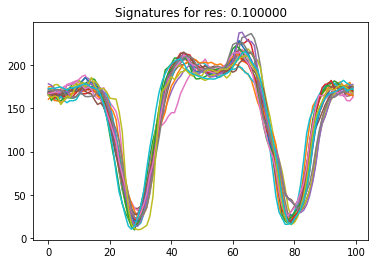

In [13]:
n_list = len(list_mask)
smoothness = 700 #Smoothness
degree = 1 #Spline degree
fit_res = 0.35
resols = np.arange(0.01,0.5,0.01) #Signature resolutions
resols = np.insert(resols,0,fit_res) #Insert resolution for signature fitting
points = 100 #Points of Spline reconstruction

refer_wat = np.empty((n_list,resols.shape[0],points)) #Initializing signature vector

for mask in xrange(n_list):
    mask_p = np.load('../dataset/Seg_Watershed/mask_wate_{}.npy'.format(list_mask[mask]))
    
    refer_temp = sign_extract(mask_p, resols) #Function for shape signature extraction
    
    refer_wat[mask] = refer_temp
    if mask > 0: #Fitting curves using the first one as basis
        prof_ref = refer_wat[0]        
        refer_wat[mask] = sign_fit(prof_ref[0], refer_temp) #Function for signature fitting
    
print "Signatures' vector size: ", refer_wat.shape

res_ex = 10
plt.figure()
plt.plot(refer_wat[:,res_ex,:].T)
plt.title("Signatures for res: %f"%(resols[res_ex]))
plt.show()

In order to get a representative correct signature, mean signature per-resolution is generated using 20 correct signatures. The mean is calculated in each point.

Mean signature size:  (50, 500)


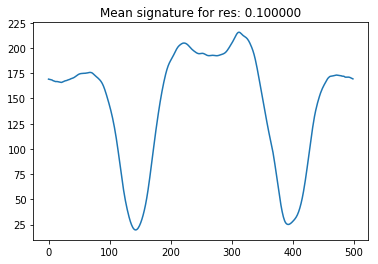

In [6]:
refer_wat_mean = np.mean(refer_wat,axis=0) #Finding mean signature per resolution

print "Mean signature size: ", refer_wat_mean.shape

plt.figure() #Plotting mean signature
plt.plot(refer_wat_mean[res_ex,:])
plt.title("Mean signature for res: %f"%(resols[res_ex]))
plt.show()

# Signature configuration

Because of the mean signature was extracted for all the resolutions, it is necessary to find resolution in that diference between RMSE for correct signature and RMSE for erroneous signature is maximum. So, 20 news segmentations were used to find this optimal resolution, being divided as 10 correct segmentations and 10 erroneous segmentations. For each segmentation, it was extracted signature for all resolutions.

Correct segmentations' vector:  (10, 50, 500)
Erroneous segmentations' vector:  (10, 50, 500)


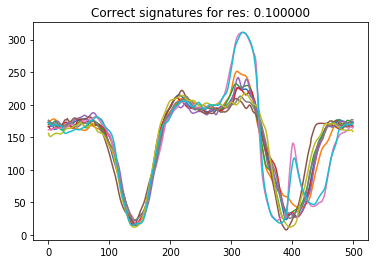

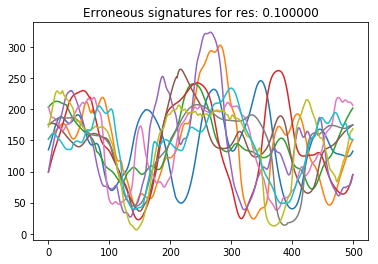

In [7]:
n_list = np.amax((len(list_normal_mask),len(list_error_mask)))
refer_wat_n = np.empty((n_list,resols.shape[0],points)) #Initializing correct signature vector
refer_wat_e = np.empty((n_list,resols.shape[0],points)) #Initializing error signature vector

for mask in xrange(n_list):
    #Loading correct mask
    mask_pn = np.load('../dataset/Seg_Watershed/mask_wate_{}.npy'.format(list_normal_mask[mask]))
    refer_temp_n = sign_extract(mask_pn, resols) #Function for shape signature extraction
    refer_wat_n[mask] = sign_fit(refer_wat_mean[0], refer_temp_n) #Function for signature fitting
    #Loading erroneous mask
    mask_pe = np.load('../dataset/Seg_Watershed/mask_wate_{}.npy'.format(list_error_mask[mask]))
    refer_temp_e = sign_extract(mask_pe, resols) #Function for shape signature extraction
    refer_wat_e[mask] = sign_fit(refer_wat_mean[0], refer_temp_e) #Function for signature fitting
           
print "Correct segmentations' vector: ", refer_wat_n.shape
print "Erroneous segmentations' vector: ", refer_wat_e.shape

plt.figure()
plt.plot(refer_wat_n[:,res_ex,:].T)
plt.title("Correct signatures for res: %f"%(resols[res_ex]))
plt.show()

plt.figure()
plt.plot(refer_wat_e[:,res_ex,:].T)
plt.title("Erroneous signatures for res: %f"%(resols[res_ex]))
plt.show()

The RMSE over the 10 correct segmentations was compared with RMSE over the 10 erroneous segmentations. As expected, RMSE for correct segmentations was greater than RMSE for erroneous segmentations along all the resolutions. In general, this is true, but optimal resolution guarantee the maximum difference between both of RMSE results: correct and erroneous.

So, to find optimal resolution, difference between correct and erroneous RMSE was calculated over all resolutions.

Optimal resolution for error detection:  0.1
Threshold for separate segmentations:  27.9496668144


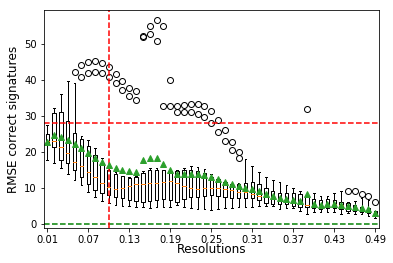

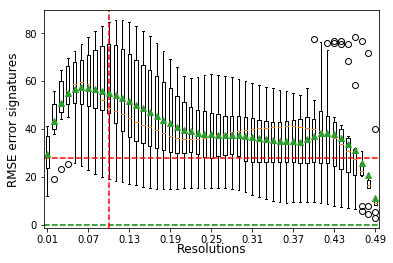

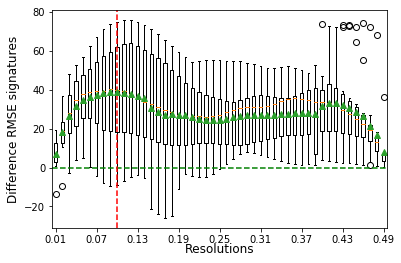

In [8]:
rmse_nacum = np.sqrt(np.sum((refer_wat_mean - refer_wat_n)**2,axis=2)/(refer_wat_mean.shape[1]))
rmse_eacum = np.sqrt(np.sum((refer_wat_mean - refer_wat_e)**2,axis=2)/(refer_wat_mean.shape[1]))

dif_dis = rmse_eacum - rmse_nacum #Difference between erroneous signatures and correct signatures

in_max_res = np.argmax(np.mean(dif_dis,axis=0)) #Finding optimal resolution at maximum difference
opt_res = resols[in_max_res]
print "Optimal resolution for error detection: ", opt_res

correct_max = np.mean(rmse_nacum[:,in_max_res]) #Finding threshold for separate segmentations
error_min = np.mean(rmse_eacum[:,in_max_res])
th_res = 0.3*(error_min-correct_max)+correct_max
print "Threshold for separate segmentations: ", th_res

#### Plotting erroneous and correct segmentation signatures

ticksx_resols = ["%.2f" % el for el in np.arange(0.01,0.5,0.01)] #Labels for plot xticks
ticksx_resols = ticksx_resols[::6]
ticksx_index = np.arange(1,50,6)

figpr = plt.figure() #Plotting mean RMSE for correct segmentations
plt.boxplot(rmse_nacum[:,1:], showmeans=True) #Element 0 was introduced only for fitting, 
                                               #in comparation is not used.
plt.axhline(y=0, color='g', linestyle='--')
plt.axhline(y=th_res, color='r', linestyle='--')
plt.axvline(x=in_max_res, color='r', linestyle='--')
plt.xlabel('Resolutions', fontsize = 12, labelpad=-2)
plt.ylabel('RMSE correct signatures', fontsize = 12)
plt.xticks(ticksx_index, ticksx_resols)
plt.show()

figpr = plt.figure() #Plotting mean RMSE for erroneous segmentations
plt.boxplot(rmse_eacum[:,1:], showmeans=True)
plt.axhline(y=0, color='g', linestyle='--')
plt.axhline(y=th_res, color='r', linestyle='--')
plt.axvline(x=in_max_res, color='r', linestyle='--')
plt.xlabel('Resolutions', fontsize = 12, labelpad=-2)
plt.ylabel('RMSE error signatures', fontsize = 12)
plt.xticks(ticksx_index, ticksx_resols)
plt.show()

figpr = plt.figure() #Plotting difference for mean RMSE over all resolutions
plt.boxplot(dif_dis[:,1:], showmeans=True)
plt.axhline(y=0, color='g', linestyle='--')
plt.axvline(x=in_max_res, color='r', linestyle='--')
plt.xlabel('Resolutions', fontsize = 12, labelpad=-2)
plt.ylabel('Difference RMSE signatures', fontsize = 12)
plt.xticks(ticksx_index, ticksx_resols)
plt.show()

The greatest difference resulted at resolution 0.1. In this resolution, threshold for separate erroneous and correct segmentations is established as 30% of the distance between the mean RMSE of the correct masks and the mean RMSE of the erroneous masks.

# Method testing

Finally, method test was performed in the 145 subject dataset: Watershed dataset with 107 segmentations, ROQS dataset with 152 segmentations and pixel-based dataset with 152 segmentations.

Final accuracy on Watershed 112 segmentations: 0.955357142857
Final accuracy on ROQS 152 segmentations: 0.953947368421


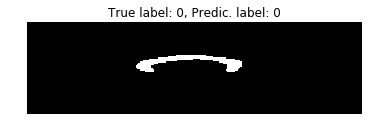

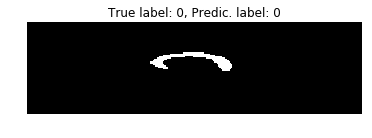

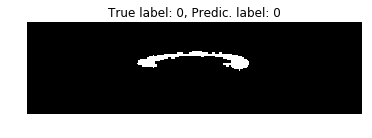

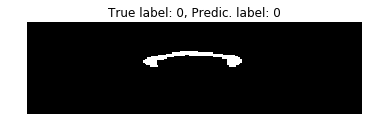

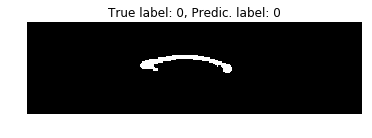

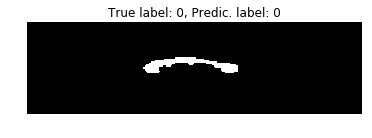

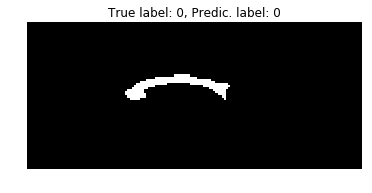

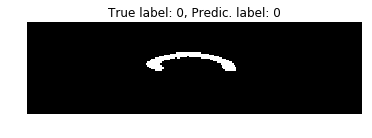

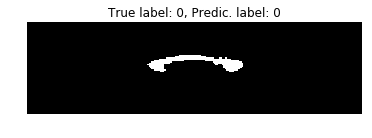

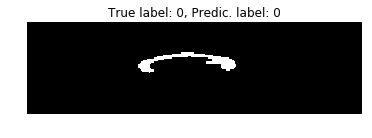

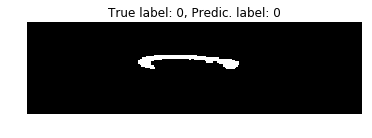

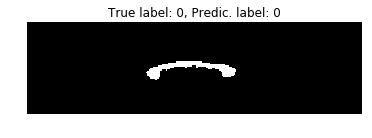

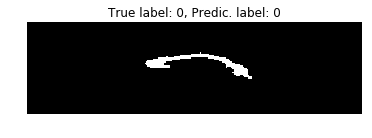

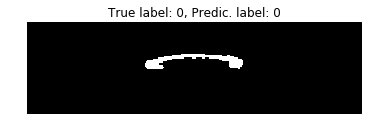

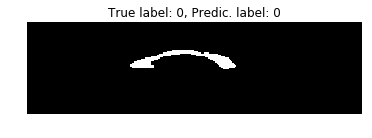

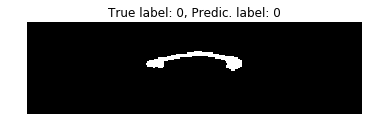

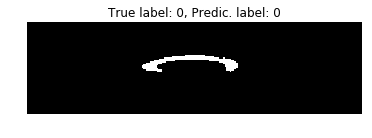

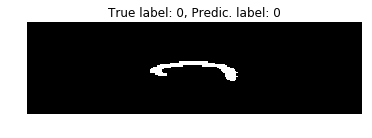

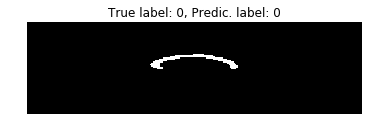

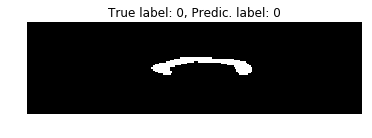

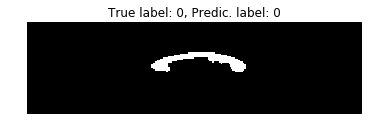

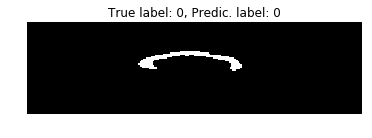

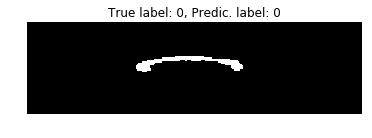

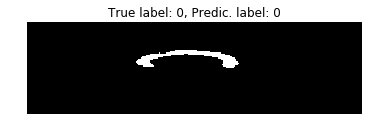

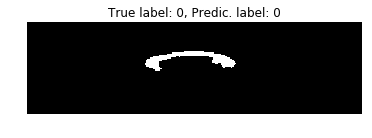

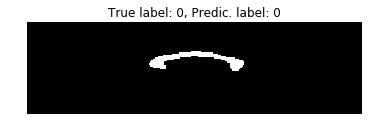

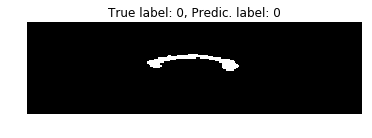

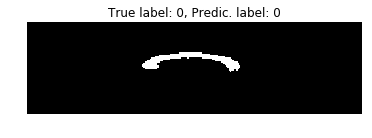

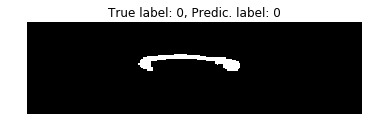

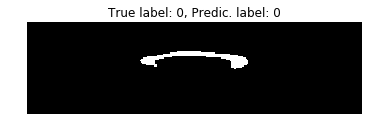

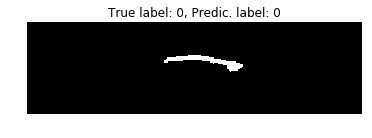

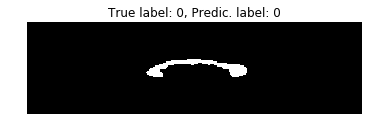

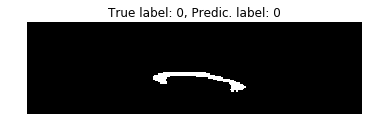

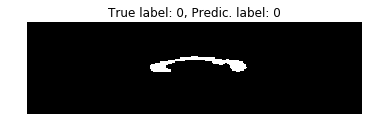

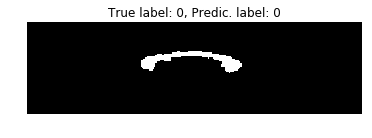

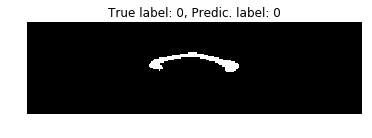

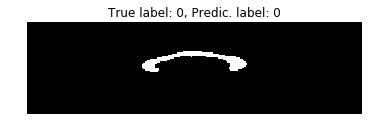

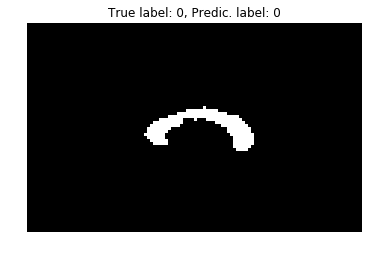

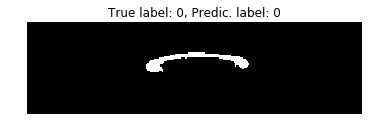

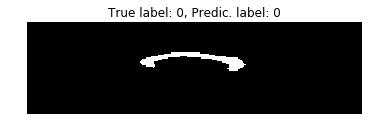

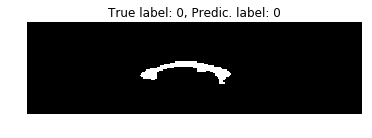

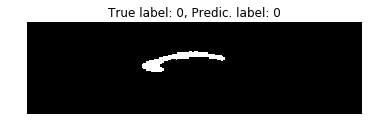

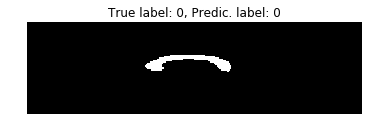

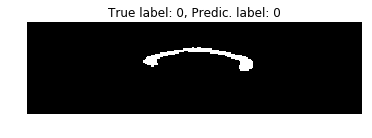

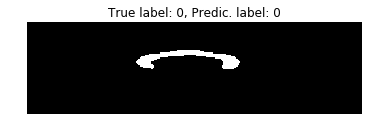

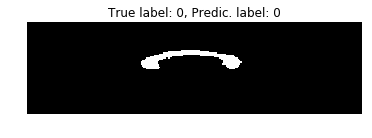

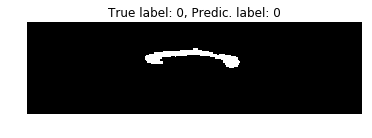

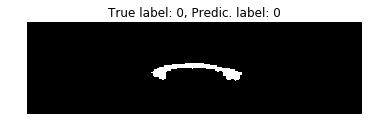

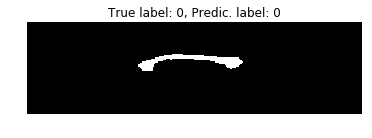

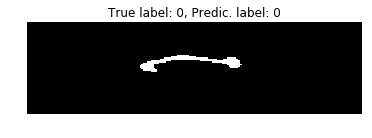

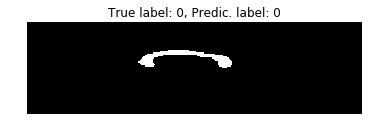

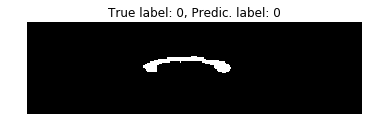

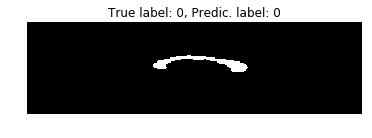

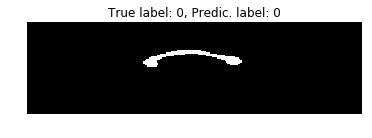

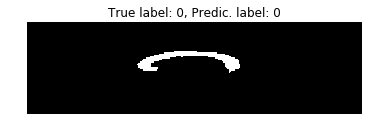

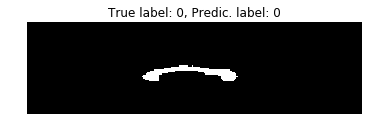

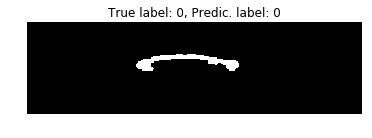

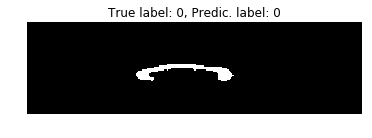

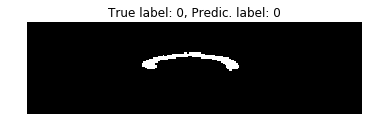

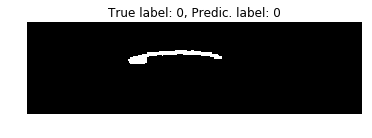

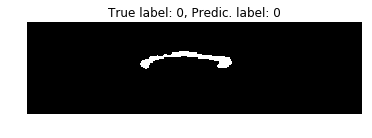

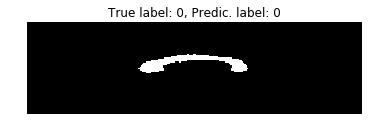

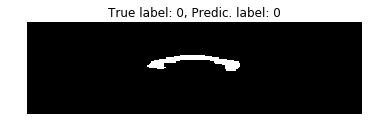

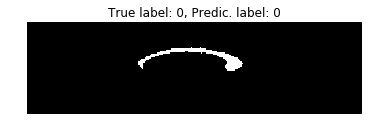

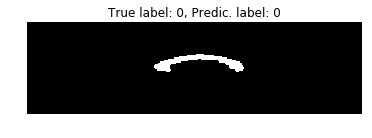

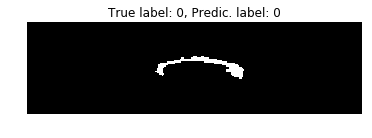

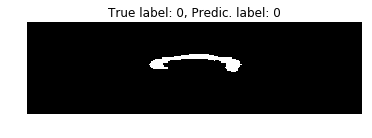

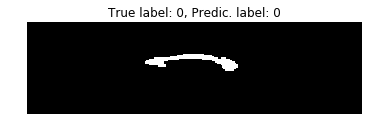

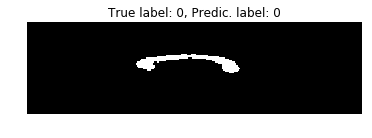

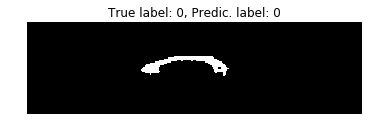

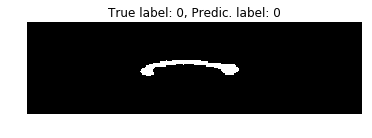

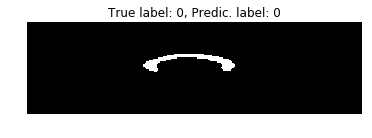

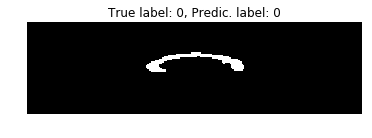

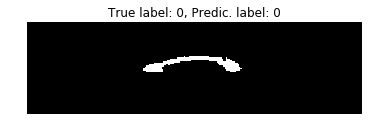

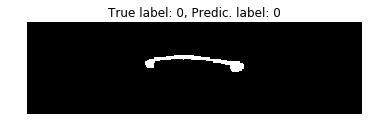

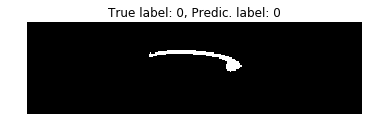

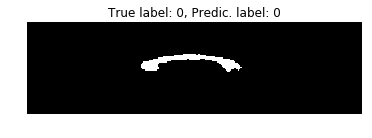

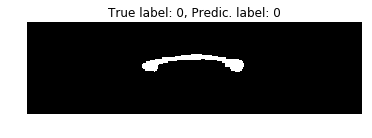

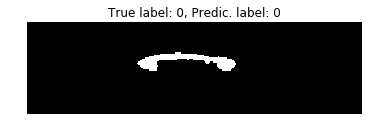

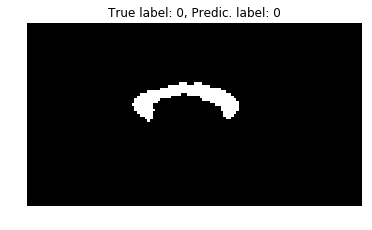

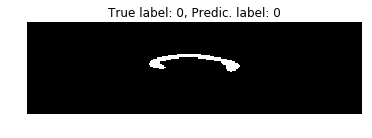

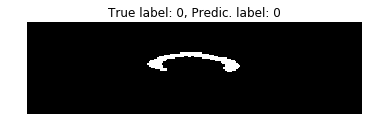

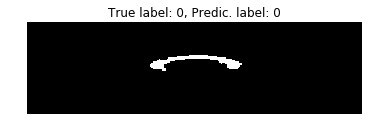

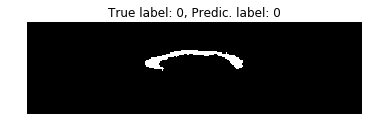

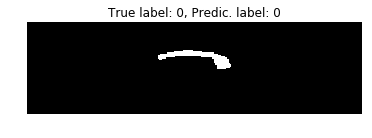

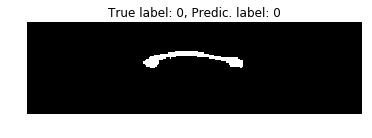

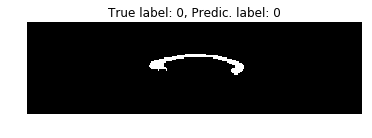

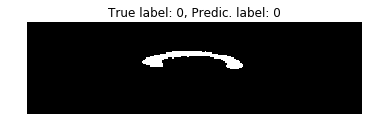

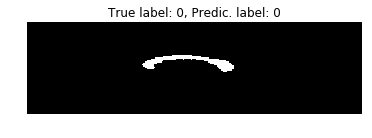

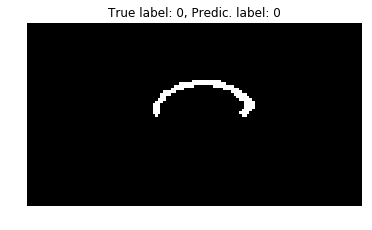

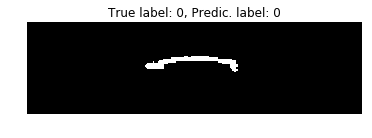

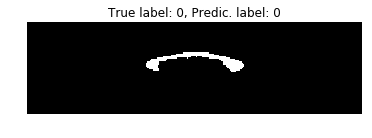

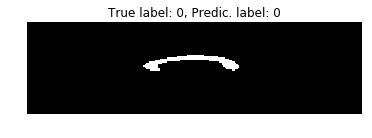

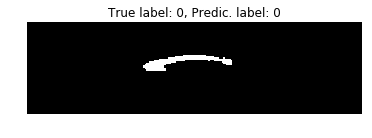

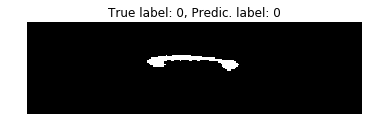

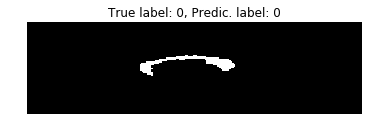

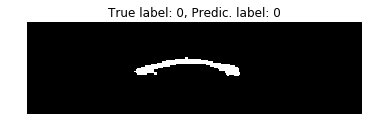

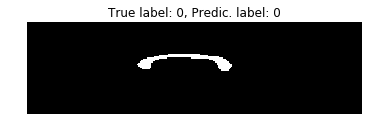

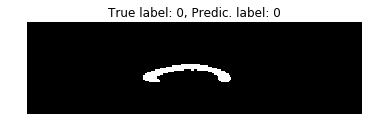

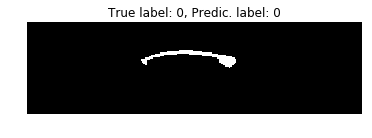

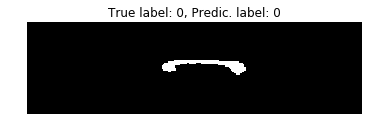

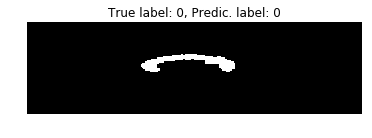

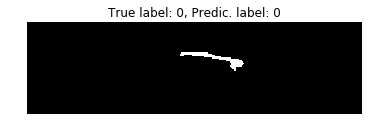

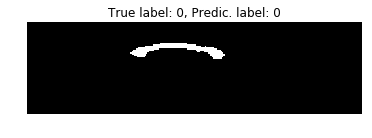

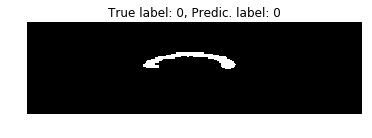

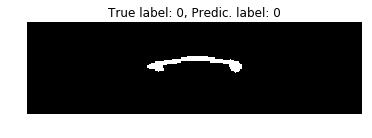

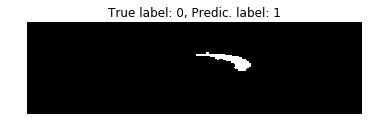

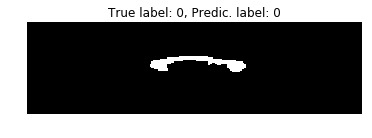

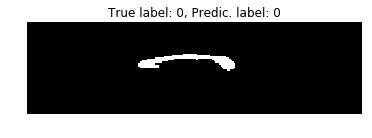

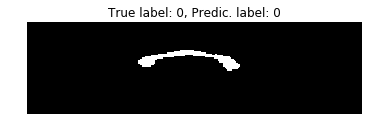

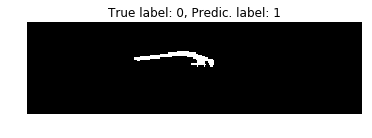

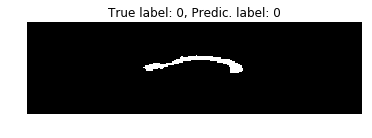

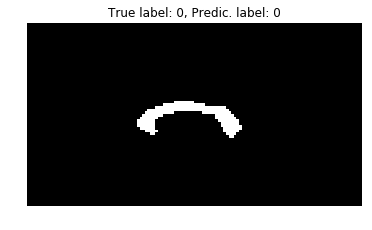

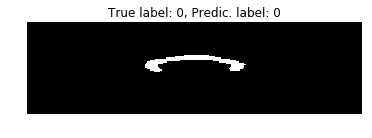

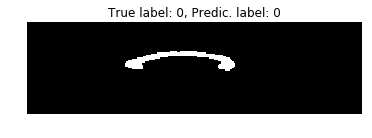

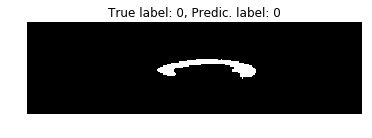

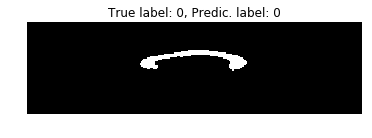

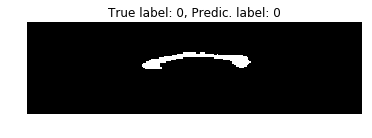

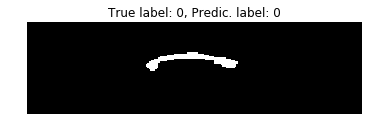

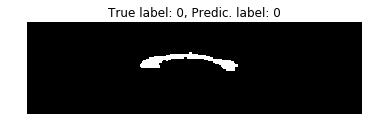

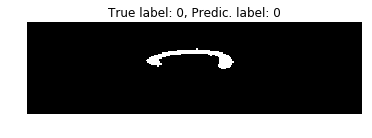

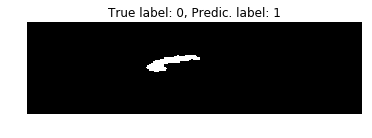

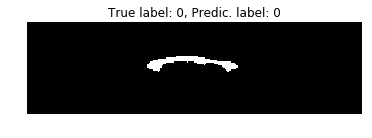

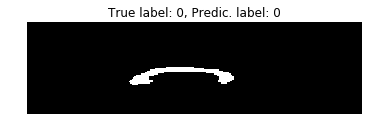

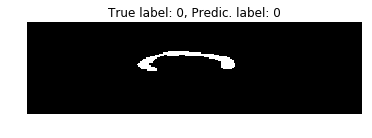

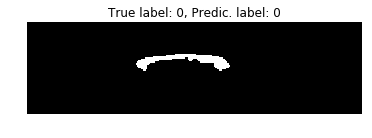

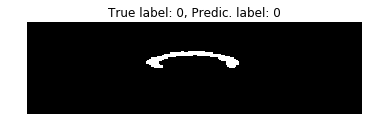

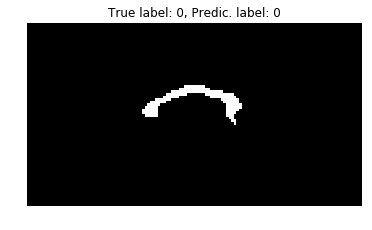

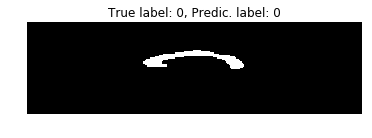

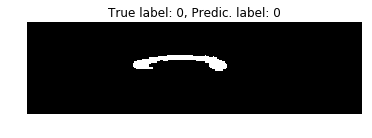

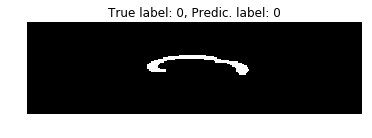

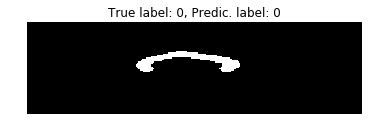

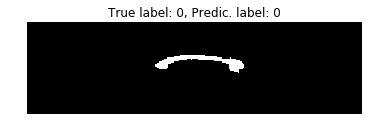

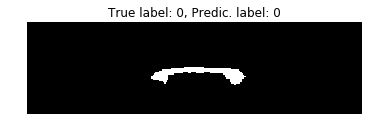

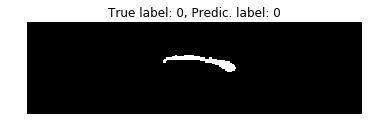

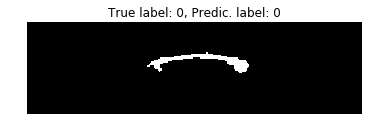

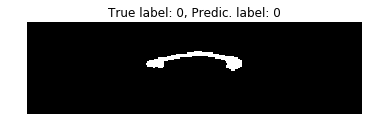

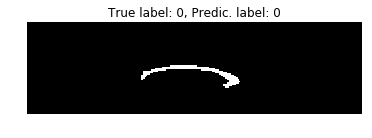

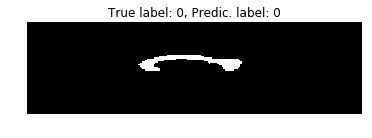

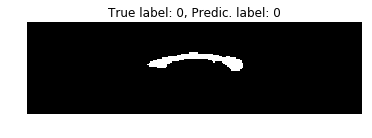

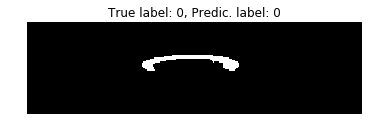

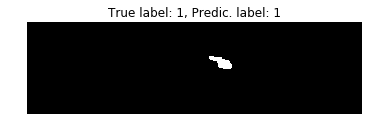

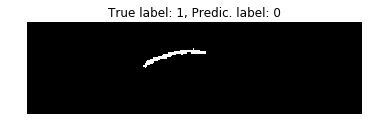

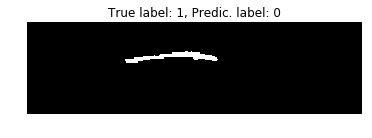

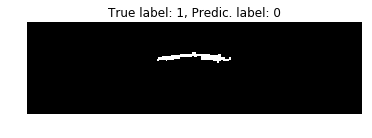

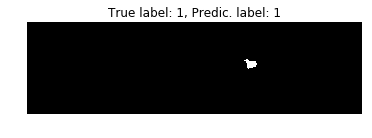

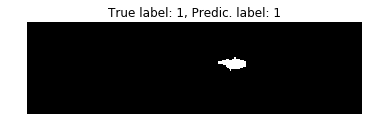

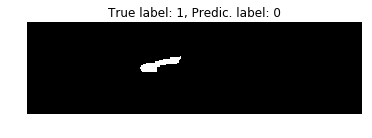

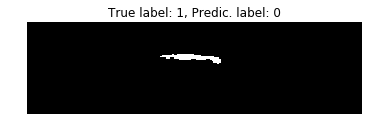

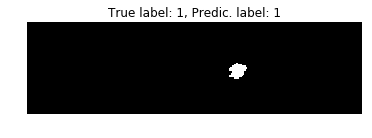

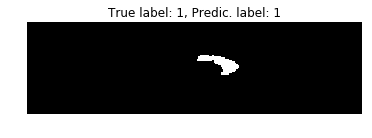

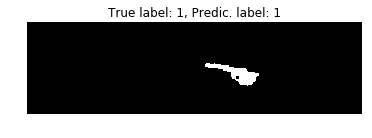

Final accuracy on pixel-based 152 segmentations: 0.947368421053


In [11]:
n_resols = [fit_res, opt_res] #Resolutions for fitting and comparison

#### Teste dataset (Watershed)
#Loading labels
seg_label = genfromtxt('../dataset/Seg_Watershed/watershed_label.csv', delimiter=',').astype('uint8')

all_seg = np.hstack((seg_label[seg_label[:,1] == 0, 0][30:],
                     seg_label[seg_label[:,1] == 1, 0][10:])) #Extracting erroneous and correct names

lab_seg = np.hstack((seg_label[seg_label[:,1] == 0, 1][30:],
                     seg_label[seg_label[:,1] == 1, 1][10:])) #Extracting erroneous and correct labels

refer_wat_mean_opt = np.vstack((refer_wat_mean[0],refer_wat_mean[in_max_res])) #Mean signature with fitting 
                                                                               #and optimal resolution

refer_seg = np.empty((all_seg.shape[0],len(n_resols),points)) #Initializing correct signature vector
in_mask = 0
for mask in all_seg:
    mask_ = np.load('../dataset/Seg_Watershed/mask_wate_{}.npy'.format(mask))
    refer_temp = sign_extract(mask_, n_resols) #Function for shape signature extraction
    refer_seg[in_mask] = sign_fit(refer_wat_mean_opt[0], refer_temp) #Function for signature fitting
    
    ###### Uncomment this block to see each segmentation with true and predicted labels
    #RMSE_ = np.sqrt(np.sum((refer_wat_mean_opt[1] - refer_seg[in_mask,1])**2)/(refer_wat_mean_opt.shape[1]))
    #plt.figure()
    #plt.axis('off')
    #plt.imshow(mask_,'gray',interpolation='none')
    #plt.title("True label: {}, Predic. label: {}".format(lab_seg[in_mask],(RMSE_>th_res).astype('uint8')))
    #plt.show()
    
    in_mask += 1

#### Segmentation evaluation result over all segmentations
RMSE = np.sqrt(np.sum((refer_wat_mean_opt[1] - refer_seg[:,1])**2,axis=1)/(refer_wat_mean_opt.shape[1]))
pred_seg = RMSE > th_res #Apply threshold
comp_seg = np.logical_not(np.logical_xor(pred_seg,lab_seg)) #Comparation method result with true labels
print "Final accuracy on Watershed {} segmentations: {}".format(len(comp_seg),
                                                         np.sum(comp_seg)/(1.0*len(comp_seg)))

#### Teste dataset (ROQS)

seg_label = genfromtxt('../dataset/Seg_ROQS/roqs_label.csv', delimiter=',').astype('uint8') #Loading labels

all_seg = np.hstack((seg_label[seg_label[:,1] == 0, 0],
                     seg_label[seg_label[:,1] == 1, 0])) #Extracting erroneous and correct names

lab_seg = np.hstack((seg_label[seg_label[:,1] == 0, 1],
                     seg_label[seg_label[:,1] == 1, 1])) #Extracting erroneous and correct labels

refer_wat_mean_opt = np.vstack((refer_wat_mean[0],refer_wat_mean[in_max_res])) #Mean signature with fitting 
                                                                               #and optimal resolution

refer_seg = np.empty((all_seg.shape[0],len(n_resols),points)) #Initializing correct signature vector
in_mask = 0
for mask in all_seg:
    mask_ = np.load('../dataset/Seg_ROQS/mask_roqs_{}.npy'.format(mask))
    refer_temp = sign_extract(mask_, n_resols) #Function for shape signature extraction
    refer_seg[in_mask] = sign_fit(refer_wat_mean_opt[0], refer_temp) #Function for signature fitting
    
    ###### Uncomment this block to see each segmentation with true and predicted labels
    #RMSE_ = np.sqrt(np.sum((refer_wat_mean_opt[1] - refer_seg[in_mask,1])**2)/(refer_wat_mean_opt.shape[1]))
    #plt.figure()
    #plt.axis('off')
    #plt.imshow(mask_,'gray',interpolation='none')
    #plt.title("True label: {}, Predic. label: {}".format(lab_seg[in_mask],(RMSE_>th_res).astype('uint8')))
    #plt.show()
    
    in_mask += 1

#### Segmentation evaluation result over all segmentations
RMSE = np.sqrt(np.sum((refer_wat_mean_opt[1] - refer_seg[:,1])**2,axis=1)/(refer_wat_mean_opt.shape[1]))
pred_seg = RMSE > th_res #Apply threshold
comp_seg = np.logical_not(np.logical_xor(pred_seg,lab_seg)) #Comparation method result with true labels
print "Final accuracy on ROQS {} segmentations: {}".format(len(comp_seg),
                                                         np.sum(comp_seg)/(1.0*len(comp_seg)))

#### Teste dataset (Pixel-based)

seg_label = genfromtxt('../dataset/Seg_pixel/pixel_label.csv', delimiter=',').astype('uint8') #Loading labels

all_seg = np.hstack((seg_label[seg_label[:,1] == 0, 0],
                     seg_label[seg_label[:,1] == 1, 0])) #Extracting erroneous and correct names

lab_seg = np.hstack((seg_label[seg_label[:,1] == 0, 1],
                     seg_label[seg_label[:,1] == 1, 1])) #Extracting erroneous and correct labels

refer_wat_mean_opt = np.vstack((refer_wat_mean[0],refer_wat_mean[in_max_res])) #Mean signature with fitting 
                                                                               #and optimal resolution

refer_seg = np.empty((all_seg.shape[0],len(n_resols),points)) #Initializing correct signature vector
in_mask = 0
for mask in all_seg:
    mask_ = np.load('../dataset/Seg_pixel/mask_pixe_{}.npy'.format(mask))
    refer_temp = sign_extract(mask_, n_resols) #Function for shape signature extraction
    refer_seg[in_mask] = sign_fit(refer_wat_mean_opt[0], refer_temp) #Function for signature fitting
    
    ###### Uncomment this block to see each segmentation with true and predicted labels
    RMSE_ = np.sqrt(np.sum((refer_wat_mean_opt[1] - refer_seg[in_mask,1])**2)/(refer_wat_mean_opt.shape[1]))
    plt.figure()
    plt.axis('off')
    plt.imshow(mask_,'gray',interpolation='none')
    plt.title("True label: {}, Predic. label: {}".format(lab_seg[in_mask],(RMSE_>th_res).astype('uint8')))
    plt.show()
    
    in_mask += 1

#### Segmentation evaluation result over all segmentations
RMSE = np.sqrt(np.sum((refer_wat_mean_opt[1] - refer_seg[:,1])**2,axis=1)/(refer_wat_mean_opt.shape[1]))
pred_seg = RMSE > th_res #Apply threshold
comp_seg = np.logical_not(np.logical_xor(pred_seg,lab_seg)) #Comparation method result with true labels
print "Final accuracy on pixel-based {} segmentations: {}".format(len(comp_seg),
                                                         np.sum(comp_seg)/(1.0*len(comp_seg)))

# Discussion and conclusion

In this work, a method for segmentation error detection in large datasets was proposed based-on shape signature. RMSE was used for comparison between signatures. Signature can be extracted in various resolutions but optimal resolution (ls=0.1) was chosen in order to get maximum separation between correct RMSE and erroneous RMSE. In this optimal resolution, threshold was fixed at 27.95 allowing separation of the two segmentation classes.The method achieved 95% of accuracy on the test Watershed segmentations, and 95% and 94% on new datasets: ROQS and pixel-based, respectively.

**40 Watershed segmentations on dataset were used to generation and configuration mean correct signature because of the greater number of erroneous segmentations** and major variability on the error shape. Because the signature holds the CC shape, the method can be extended to new datasets segmented with any method. Accuracy and generalization can be improved varying the segmentations used to generate and adjust the mean correct signature.